In [1]:
import gzip
import os
import pickle

model_dir = '../data/processed/spell_checker/models'


def load_model(filepath):
    with gzip.open(filepath, 'rb') as f:
        return pickle.load(f)


rf_apkbr = load_model(filepath=os.path.join(model_dir, 'rf_classifier_model_freq_1000000_apkbr_ru.txt.pkl.gz'))
rf_elgkbr = load_model(filepath=os.path.join(model_dir, 'rf_classifier_model_freq_1000000_elgkbr_ru.txt.pkl.gz'))
rf_oshhamaho = load_model(filepath=os.path.join(model_dir, 'rf_classifier_model_freq_1000000_oshhamaho.txt.pkl.gz'))

In [2]:
from src.logic.spell_checker.feature_filler import fill_features
import pandas as pd
from tqdm import tqdm

from src.logic.spell_checker.manager.tokenization import TokenizerManager
from src.logic.spell_checker.manager.ngram import NGramAnalyzer
from src.logic.spell_checker.manager.word_trie import WordTrie


def prepare_features_manager(model_from_file):
    df = pd.read_csv(f'../data/processed/word_freqs/{model_from_file}'.replace('txt', 'csv'), sep=',')
    trie_words = df[df['freq'] > 1]['word'].values.tolist()
    print(len(trie_words))

    word_trie = WordTrie(words=trie_words)
    word_trie.make()
    ngram_analyzer = NGramAnalyzer(word_trie.get_words(), ngrams=(2, 3, 4))
    tokenizer_manager = TokenizerManager(
        tokenizer_paths={
            'unigram_5k': '../data/processed/tokenizer/words_unigram_5000.tokenizer.json',
            'bpe_5k': '../data/processed/tokenizer/bpe_5000.tokenizer.json',
        }
    )

    return word_trie, ngram_analyzer, tokenizer_manager


def prepare_test_data(file_name):
    with open(f'../data/processed/word_freqs/{file_name}') as f:
        test_words = f.read().split('\n')

    word_trie, ngram_analyzer, tokenizer_manager = prepare_features_manager(file_name)

    test_words_data = []
    pgbar = tqdm(test_words, desc=f'prepare test data {file_name}')
    for word in pgbar:
        test_words_data.append(
            fill_features(
                word,
                word_trie=word_trie,
                tokenizer_manager=tokenizer_manager,
                ngram_analyzer=ngram_analyzer,
            )
        )

    test_df = pd.DataFrame(test_words_data)
    test_df.dropna(inplace=True)
    return test_df


test_df_apkbr = prepare_test_data('freq_1000000_apkbr_ru.txt')
test_df_elgkbr = prepare_test_data('freq_1000000_elgkbr_ru.txt')
test_df_oshhamaho = prepare_test_data('freq_1000000_oshhamaho.txt')

196116


prepare test data freq_1000000_apkbr_ru.txt: 100%|██████████| 453533/453533 [01:17<00:00, 5863.71it/s]


95635


prepare test data freq_1000000_elgkbr_ru.txt: 100%|██████████| 245785/245785 [00:42<00:00, 5761.82it/s]


179574


prepare test data freq_1000000_oshhamaho.txt: 100%|██████████| 483338/483338 [01:27<00:00, 5512.93it/s]


In [4]:
features_columns = [
    # 'word', 
    'word_len',
    'unigram_5k_char_count/token_count',
    # 'unigram_5k_tokens', 
    'unigram_5k_tokens_count',
    # 'unigram_5k_token_ids',
    # 'unigram_5k_prefix', 
    'unigram_5k_prefix_len',
    # 'unigram_5k_prefix_id',
    # 'unigram_5k_suffix', 
    'unigram_5k_suffix_len',
    # 'unigram_5k_suffix_id',
    'bpe_5k_char_count/token_count',
    # 'bpe_5k_tokens', 
    'bpe_5k_tokens_count',
    # 'bpe_5k_token_ids', 
    # 'bpe_5k_prefix', 
    'bpe_5k_prefix_len',
    # 'bpe_5k_prefix_id', 
    # 'bpe_5k_suffix', 
    'bpe_5k_suffix_len',
    # 'bpe_5k_suffix_id', 

    '2gram_treshold_10',
    '2gram_treshold_m_10',
    '2gram_treshold_100',
    '2gram_treshold_m_100',
    '2gram_treshold_200',
    '2gram_treshold_m_200',
    '2gram_treshold_500',
    '2gram_treshold_m_500',
    '2gram_treshold_1000',
    '2gram_treshold_m_1000',

    '3gram_treshold_10',
    '3gram_treshold_m_10',
    '3gram_treshold_50',
    '3gram_treshold_m_50',
    '3gram_treshold_100',
    '3gram_treshold_m_100',
    '3gram_treshold_200',
    '3gram_treshold_m_200',
    '3gram_treshold_500',
    '3gram_treshold_m_500',

    '4gram_treshold_10',
    '4gram_treshold_m_10',
    '4gram_treshold_20',
    '4gram_treshold_m_20',
    '4gram_treshold_30',
    '4gram_treshold_m_30',
    '4gram_treshold_50',
    '4gram_treshold_m_50',
    '4gram_treshold_100',
    '4gram_treshold_m_100',

    # 'longest_prefix', 
    'longest_prefix_len',
    'longest_prefix/word_len',
    # 'longest_suffix', 
    'longest_suffix_len',
    'longest_suffix/word_len',
    # 'target',
]

models = {
    'apkbr': rf_apkbr,
    'elgkbr': rf_elgkbr,
    'oshhamaho': rf_oshhamaho,
}

test_dfs = {
    'apkbr': test_df_apkbr,
    'elgkbr': test_df_elgkbr,
    'oshhamaho': test_df_oshhamaho,
}

result_dir = '../data/processed/spell_checker/results'
os.makedirs(result_dir, exist_ok=True)

for model_name, model in models.items():
    for test_df_name, test_df in test_dfs.items():
        calculated_df = model.predict(test_df[features_columns])
        test_df['calc'] = calculated_df
        word_calc = test_df[['word', 'calc']]

        word_calc.to_csv(f'../data/processed/spell_checker/results/model_{model_name}__{test_df_name}.csv', index=False)

In [5]:
all_calc_df = None
for model_name, _ in models.items():
    for test_df_name, _ in test_dfs.items():
        word_calc_df = pd.read_csv(os.path.join(result_dir, f'model_{model_name}__{test_df_name}.csv'))
        word_calc_df['calc'].astype(int)
        word_calc_df.rename(columns={'calc': f'calc_model_{model_name}__text_{test_df_name}'}, inplace=True)

        if all_calc_df is None:
            all_calc_df = word_calc_df
        else:
            all_calc_df = pd.merge(all_calc_df, word_calc_df, how='outer', on='word')

In [6]:
import csv
import numpy as np

all_calc_df.replace({np.nan: None}, inplace=True)
all_calc_df.sort_values(by=['word'], inplace=True)

In [7]:
all_calc_df['sum_calculated_conf'] = all_calc_df.apply(
    lambda row: sum(
        [
            row[col]
            for col in all_calc_df.columns.tolist()
            if col.startswith('calc_model_') and row[col] is not None
        ]
    ),
    axis=1
)

In [8]:
all_calc_df['null_count'] = all_calc_df.apply(
    lambda row: sum(
        [
            1
            for col in all_calc_df.columns.tolist()
            if col.startswith('calc_model_') and row[col] is None
        ]
    ),
    axis=1
)

In [9]:
all_calc_df.to_csv(os.path.join(result_dir, 'all_calc.csv'), sep=',', index=False, quoting=csv.QUOTE_MINIMAL)

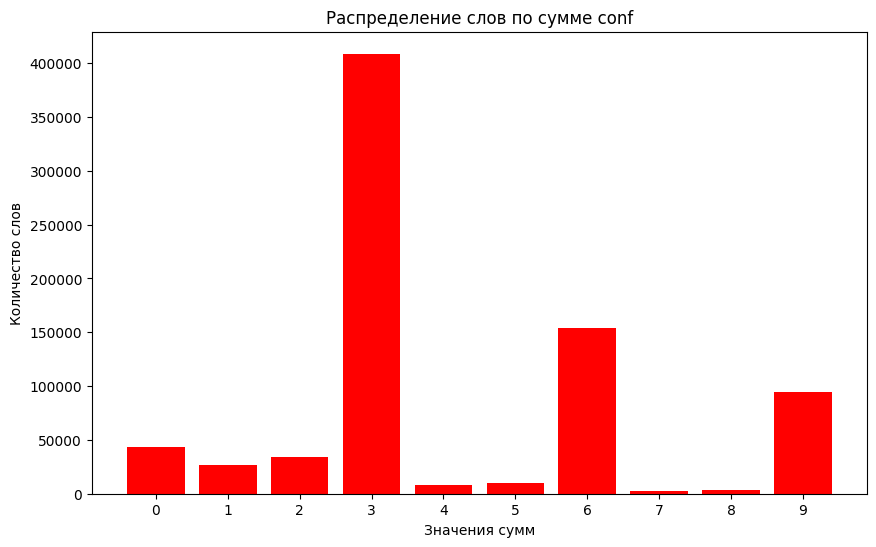

In [17]:
import matplotlib.pyplot as plt

words_by_calc_conf = all_calc_df['sum_calculated_conf'].value_counts()
words_by_calc_conf = words_by_calc_conf.sort_index()

plt.figure(figsize=(10, 6))
plt.bar(
    words_by_calc_conf.index,
    words_by_calc_conf.values,
    color='r',
    align="center"
)  # Столбчатая диаграмма
plt.title('Распределение слов по сумме conf')
plt.xlabel('Значения сумм')
plt.ylabel('Количество слов')
plt.xticks(words_by_calc_conf.index)

plt.show()

Для дальнейшего разбора сохраним выборку слов, по сумме confidence.

*Если сумма 9, то слово было в каждом из 3 источников и все три модели сочли слово правильным*    

In [12]:
words_result_dir = '../data/interim/spell_checker/results/words'
os.makedirs(words_result_dir, exist_ok=True)

for val in all_calc_df['sum_calculated_conf'].value_counts().index.tolist():
    words = all_calc_df[all_calc_df['sum_calculated_conf'] == val]['word'].values.tolist()
    with open(os.path.join(words_result_dir, f'words_sum_calculated_conf_{val}.txt'), 'w') as f:
        f.write('\n'.join(sorted(words)))

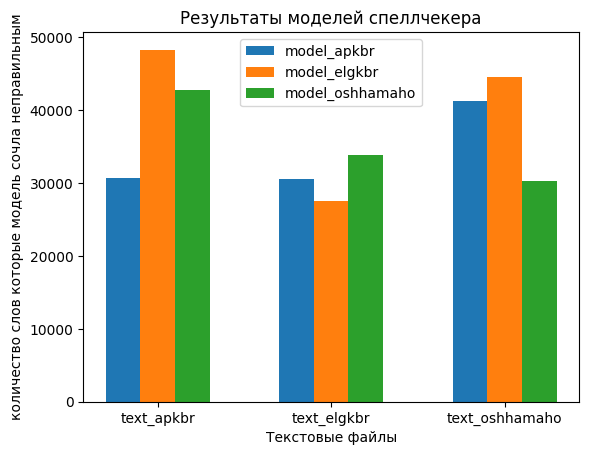

In [50]:
show_valid = False

def filter_value(value):
    if show_valid:
        return int(value == 1)  # valid words

    return int(value == 0)  # invalid words


plot_data = {
    'text_apkbr': {
        'model_apkbr': all_calc_df['calc_model_apkbr__text_apkbr'].apply(filter_value).sum(),
        'model_elgkbr': all_calc_df['calc_model_elgkbr__text_apkbr'].apply(filter_value).sum(),
        'model_oshhamaho': all_calc_df['calc_model_oshhamaho__text_apkbr'].apply(filter_value).sum(),
    },
    'text_elgkbr': {
        'model_apkbr': all_calc_df['calc_model_apkbr__text_elgkbr'].apply(filter_value).sum(),
        'model_elgkbr': all_calc_df['calc_model_elgkbr__text_elgkbr'].apply(filter_value).sum(),
        'model_oshhamaho': all_calc_df['calc_model_oshhamaho__text_elgkbr'].apply(filter_value).sum(),
    },
    'text_oshhamaho': {
        'model_apkbr': all_calc_df['calc_model_apkbr__text_oshhamaho'].apply(filter_value).sum(),
        'model_elgkbr': all_calc_df['calc_model_elgkbr__text_oshhamaho'].apply(filter_value).sum(),
        'model_oshhamaho': all_calc_df['calc_model_oshhamaho__text_oshhamaho'].apply(filter_value).sum(),
    }
}

labels = list(plot_data.keys())
models = list(plot_data['text_apkbr'].keys())
n_models = len(models)
x = np.arange(len(labels))  # Метки по оси x
width = 0.2

fig, ax = plt.subplots()
for i, model in enumerate(models):
    model_data = [plot_data[label][model] for label in labels]
    ax.bar(x + i * width, model_data, width, label=model)

ax.set_title('Результаты моделей спеллчекера')
ax.set_xlabel('Текстовые файлы')
predict_label = 'правильным' if show_valid else 'неправильным'
ax.set_ylabel(f'количество слов которые модель сочла {predict_label}')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()